## Food Recommendation System

**Introduction**

This is a Machine Learning Food Recommendation System Based on Calories using the combination of Nearest Neighbours (NN) and Naive Bayes (NB) algorithms

We'll use the Pandas library for data processing and scikit-learn for implementing the Nearest Neighbors and Naive Bayes algorithms.
We used food dataset from food.com (recipies.csv).

The recommendation system combines the strengths of Nearest Neighbors (finding similar recipes based on food contents) and Naive Bayes (suggesting low-calorie alternatives) to provide food recommendations for overweight and obese individuals based on their dietary preferences. It leverages the dataset's information to make informed suggestions for healthier food choices while considering the users' specific nutritional needs.

**How it works**

A user provides a barcode, the recommendation system uses the Nearest Neighbors algorithm to find the recipe in the dataset that has the closest nutritional content to the provided food. The similarity between recipes is determined based on the feature values.

Once the nearest recipe is identified, the recommendation system uses Naive Bayes to suggest a similar recipe with fewer calories. It predicts the target variable (calories) using the provided barcode data and looks for a recipe with a calorie content of less than 400.

Let's start with the implementation:

**Data Collection:**

We will load data from the dataset into the pandas dataframe. This dataset contains information about various recipes, including their nutritional contents and calorie values

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.preprocessing import StandardScaler, LabelEncoder
from sklearn.pipeline import Pipeline
from sklearn.neighbors import KNeighborsClassifier, NearestNeighbors, KNeighborsRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report, r2_score


# Load the dataset
df = pd.read_csv('recipes.csv', low_memory=False)

df.head()

,RecipeId,Barcode,Name,AuthorId,AuthorName,CookTime,PrepTime,TotalTime,DatePublished,Description,...,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,RecipeYield,RecipeInstructions
0,38.0,*38*,Low-Fat Berry Blue Frozen Dessert,1533.0,Dancer,PT24H,PT45M,PT24H45M,1999-08-09T21:46:00Z,Make and share this Low-Fat Berry Blue Frozen ...,...,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,NaN,"c(""Toss 2 cups berries with sugar."", ""Let stan..."
1,39.0,*39*,Biryani,1567.0,elly9812,PT25M,PT4H,PT4H25M,1999-08-29T13:12:00Z,Make and share this Biryani recipe from Food.com.,...,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,NaN,"c(""Soak saffron in warm milk for 5 minutes and..."
2,40.0,*40*,Best Lemonade,1566.0,Stephen Little,PT5M,PT30M,PT35M,1999-09-05T19:52:00Z,This is from one of my first Good House Keepi...,...,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,NaN,"c(""Into a 1 quart Jar with tight fitting lid, ..."
3,41.0,*41*,Carina's Tofu-Vegetable Kebabs,1586.0,Cyclopz,PT20M,PT24H,PT24H20M,1999-09-03T14:54:00Z,This dish is best prepared a day in advance to...,...,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,4 kebabs,"c(""Drain the tofu, carefully squeezing out exc..."
4,42.0,*42*,Cabbage Soup,1538.0,Duckie067,PT30M,PT20M,PT50M,1999-09-19T06:19:00Z,Make and share this Cabbage Soup recipe from F...,...,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,NaN,"c(""Mix everything together and bring to a boil..."


**Data Cleaning:**

After loading the dataset, we perform data cleaning to handle missing values or incorrect data. In this case, we remove rows with missing values

In [2]:
# Confirm Columns
df.columns

Index(['RecipeId', 'Barcode', 'Name', 'AuthorId', 'AuthorName', 'CookTime',
       'PrepTime', 'TotalTime', 'DatePublished', 'Description', 'Images',
       'RecipeCategory', 'Keywords', 'RecipeIngredientQuantities',
       'RecipeIngredientParts', 'AggregatedRating', 'ReviewCount', 'Calories',
       'FatContent', 'SaturatedFatContent', 'CholesterolContent',
       'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent',
       'ProteinContent', 'RecipeServings', 'RecipeYield',
       'RecipeInstructions'],
      dtype='object')

In [3]:
# Select necessary columns
df = df[['RecipeId', 'Barcode', 'Name', 'CookTime', 'PrepTime', 'TotalTime', 'Calories',
       'FatContent', 'SaturatedFatContent', 'CholesterolContent',
       'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent',
       'ProteinContent', 'RecipeServings', 'DatePublished', 'RecipeInstructions', 'Images']]

df

,RecipeId,Barcode,Name,CookTime,PrepTime,TotalTime,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,DatePublished,RecipeInstructions,Images
0,38.0,*38*,Low-Fat Berry Blue Frozen Dessert,PT24H,PT45M,PT24H45M,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,1999-08-09T21:46:00Z,"c(""Toss 2 cups berries with sugar."", ""Let stan...","c(""https://img.sndimg.com/food/image/upload/w_..."
1,39.0,*39*,Biryani,PT25M,PT4H,PT4H25M,1110.7,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,1999-08-29T13:12:00Z,"c(""Soak saffron in warm milk for 5 minutes and...","c(""https://img.sndimg.com/food/image/upload/w_..."
2,40.0,*40*,Best Lemonade,PT5M,PT30M,PT35M,311.1,0.2,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,1999-09-05T19:52:00Z,"c(""Into a 1 quart Jar with tight fitting lid, ...","c(""https://img.sndimg.com/food/image/upload/w_..."
3,41.0,*41*,Carina's Tofu-Vegetable Kebabs,PT20M,PT24H,PT24H20M,536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,1999-09-03T14:54:00Z,"c(""Drain the tofu, carefully squeezing out exc...","c(""https://img.sndimg.com/food/image/upload/w_..."
4,42.0,*42*,Cabbage Soup,PT30M,PT20M,PT50M,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,1999-09-19T06:19:00Z,"c(""Mix everything together and bring to a boil...","""https://img.sndimg.com/food/image/upload/w_55..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048538,NaN,(),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048539,NaN,(),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048540,NaN,(),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048541,NaN,(),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [4]:
# Handle fields with null values
df[df.isnull().any(axis=1)]

,RecipeId,Barcode,Name,CookTime,PrepTime,TotalTime,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,DatePublished,RecipeInstructions,Images
8,46.0,*46*,A Jad - Cucumber Pickle,NaN,PT25M,PT25M,4.3,0.0,0.0,0.0,0.7,1.1,0.2,0.2,0.1,NaN,1999-08-11T19:48:00Z,"c(""Slice the cucumber in four lengthwise, then...",character(0)
9,47.0,*47*,Butter Pecan Cookies,PT9M,PT55M,PT1H4M,69.0,5.6,1.4,6.3,15.0,4.5,0.6,1.6,0.8,NaN,1999-09-07T09:01:00Z,"c(""Preheat oven to 350 degrees."", ""Cream butte...","c(""https://img.sndimg.com/food/image/upload/w_..."
10,48.0,*48*,Boston Cream Pie,NaN,PT2H15M,PT2H15M,688.2,36.4,12.9,105.9,722.3,84.0,1.6,46.2,8.8,8.0,1999-08-24T04:35:00Z,"c(""Beat egg whites until soft peaks form."", ""G...",character(0)
12,50.0,*50*,Biscotti Di Prato,PT50M,PT20M,PT1H10M,89.4,2.6,0.3,16.6,23.5,14.5,0.8,7.3,2.3,NaN,1999-08-31T21:19:00Z,"c(""EGG WASH 1 Egg, large 1 tsp Water In the bo...","""https://img.sndimg.com/food/image/upload/w_55..."
14,52.0,*52*,Cafe Cappuccino,NaN,PT5M,PT5M,62.2,0.1,0.0,1.3,36.6,12.8,0.0,11.8,2.7,18.0,1999-08-31T21:05:00Z,"c(""Stir ingredients together."", ""Process in a ...","c(""https://img.sndimg.com/food/image/upload/w_..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1048538,NaN,(),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048539,NaN,(),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048540,NaN,(),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1048541,NaN,(),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [5]:
# Drop fields with NaN values
df = df.dropna()

df

,RecipeId,Barcode,Name,CookTime,PrepTime,TotalTime,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,DatePublished,RecipeInstructions,Images
0,38.0,*38*,Low-Fat Berry Blue Frozen Dessert,PT24H,PT45M,PT24H45M,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,1999-08-09T21:46:00Z,"c(""Toss 2 cups berries with sugar."", ""Let stan...","c(""https://img.sndimg.com/food/image/upload/w_..."
1,39.0,*39*,Biryani,PT25M,PT4H,PT4H25M,1110.7,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,1999-08-29T13:12:00Z,"c(""Soak saffron in warm milk for 5 minutes and...","c(""https://img.sndimg.com/food/image/upload/w_..."
2,40.0,*40*,Best Lemonade,PT5M,PT30M,PT35M,311.1,0.2,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,1999-09-05T19:52:00Z,"c(""Into a 1 quart Jar with tight fitting lid, ...","c(""https://img.sndimg.com/food/image/upload/w_..."
3,41.0,*41*,Carina's Tofu-Vegetable Kebabs,PT20M,PT24H,PT24H20M,536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,1999-09-03T14:54:00Z,"c(""Drain the tofu, carefully squeezing out exc...","c(""https://img.sndimg.com/food/image/upload/w_..."
4,42.0,*42*,Cabbage Soup,PT30M,PT20M,PT50M,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,1999-09-19T06:19:00Z,"c(""Mix everything together and bring to a boil...","""https://img.sndimg.com/food/image/upload/w_55..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,2632.0,*2632*,Stir-Fry Beef & Spinach with Noodles,PT30M,PT0S,PT30M,299.0,4.2,0.6,0.5,599.9,54.4,4.2,8.0,12.8,4.0,1999-08-13T13:50:00Z,"c(""Stack beef steaks; cut lengthwise in half a...",character(0)
1196,2633.0,*2633*,"Beef, Pepper & Mushroom Kabobs",PT30M,PT0S,PT30M,208.8,8.3,2.2,68.0,213.9,6.1,1.5,3.9,27.6,4.0,1999-08-11T19:51:00Z,"c(""Trim fat from beef steak; cut into 1 1/4-in...","""https://img.sndimg.com/food/image/upload/w_55..."
1202,2639.0,*2639*,Sweet Chicken Curry,PT25M,PT10M,PT35M,114.2,8.1,2.2,35.5,37.2,1.0,0.2,0.3,9.0,48.0,1999-08-13T13:28:00Z,"c(""In a pot, brown the meat, onions and garlic...",character(0)
1213,2650.0,*2650*,Beer Can Chicken,PT1H30M,PT30M,PT2H,771.5,53.2,15.2,243.8,358.0,5.2,0.2,0.6,57.9,8.0,1999-08-23T12:45:00Z,"c(""Place wood chips in bowl."", ""Pop tabs of ea...","c(""https://img.sndimg.com/food/image/upload/w_..."


In [6]:
df.dtypes

RecipeId               float64
Barcode                 object
Name                    object
CookTime                object
PrepTime                object
TotalTime               object
Calories               float64
FatContent             float64
SaturatedFatContent    float64
CholesterolContent     float64
SodiumContent          float64
CarbohydrateContent    float64
FiberContent           float64
SugarContent           float64
ProteinContent         float64
RecipeServings         float64
DatePublished           object
RecipeInstructions      object
Images                  object
dtype: object

In [7]:
# # Convert cook, prep, and total time to numeric values in minutes
df['CookTime'] = df['CookTime'].str.extract('(\d+)').astype(float) * 60
df['PrepTime'] = df['PrepTime'].str.extract('(\d+)').astype(float) * 60
df['TotalTime'] = df['TotalTime'].str.extract('(\d+)').astype(float) * 60

# Convert Barcode to digits
df['Barcode'] = df['Barcode'].str.extract('(\d+)').astype(int)
# Convert 'DatePublished' to datetime objects
df['DatePublished'] = pd.to_datetime(df['DatePublished'])
# df["Images"] = df["Images"].astype(str)
# # Remove extra quotes from the "Images" column
# df["Images"] = df["Images"].str.replace('"', '').str.replace("''", "'")


/var/folders/z4/t7pwvzvs4zxcw47ks_tgdgjw0000gn/T/ipykernel_51825/834213256.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['CookTime'] = df['CookTime'].str.extract('(\d+)').astype(float) * 60
/var/folders/z4/t7pwvzvs4zxcw47ks_tgdgjw0000gn/T/ipykernel_51825/834213256.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['PrepTime'] = df['PrepTime'].str.extract('(\d+)').astype(float) * 60
/var/folders/z4/t7pwvzvs4zxcw47ks_tgdgjw0000gn/T/ipykernel_51825/834213256.py:4: SettingWithCopyWarning: 
A value 

In [8]:
df.dtypes

RecipeId                           float64
Barcode                              int64
Name                                object
CookTime                           float64
PrepTime                           float64
TotalTime                          float64
Calories                           float64
FatContent                         float64
SaturatedFatContent                float64
CholesterolContent                 float64
SodiumContent                      float64
CarbohydrateContent                float64
FiberContent                       float64
SugarContent                       float64
ProteinContent                     float64
RecipeServings                     float64
DatePublished          datetime64[ns, UTC]
RecipeInstructions                  object
Images                              object
dtype: object

In [9]:
df

,RecipeId,Barcode,Name,CookTime,PrepTime,TotalTime,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,DatePublished,RecipeInstructions,Images
0,38.0,38,Low-Fat Berry Blue Frozen Dessert,1440.0,2700.0,1440.0,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,1999-08-09 21:46:00+00:00,"c(""Toss 2 cups berries with sugar."", ""Let stan...","c(""https://img.sndimg.com/food/image/upload/w_..."
1,39.0,39,Biryani,1500.0,240.0,240.0,1110.7,58.8,16.6,372.8,368.4,84.4,9.0,20.4,63.4,6.0,1999-08-29 13:12:00+00:00,"c(""Soak saffron in warm milk for 5 minutes and...","c(""https://img.sndimg.com/food/image/upload/w_..."
2,40.0,40,Best Lemonade,300.0,1800.0,2100.0,311.1,0.2,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,1999-09-05 19:52:00+00:00,"c(""Into a 1 quart Jar with tight fitting lid, ...","c(""https://img.sndimg.com/food/image/upload/w_..."
3,41.0,41,Carina's Tofu-Vegetable Kebabs,1200.0,1440.0,1440.0,536.1,24.0,3.8,0.0,1558.6,64.2,17.3,32.1,29.3,2.0,1999-09-03 14:54:00+00:00,"c(""Drain the tofu, carefully squeezing out exc...","c(""https://img.sndimg.com/food/image/upload/w_..."
4,42.0,42,Cabbage Soup,1800.0,1200.0,3000.0,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,1999-09-19 06:19:00+00:00,"c(""Mix everything together and bring to a boil...","""https://img.sndimg.com/food/image/upload/w_55..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,2632.0,2632,Stir-Fry Beef & Spinach with Noodles,1800.0,0.0,1800.0,299.0,4.2,0.6,0.5,599.9,54.4,4.2,8.0,12.8,4.0,1999-08-13 13:50:00+00:00,"c(""Stack beef steaks; cut lengthwise in half a...",character(0)
1196,2633.0,2633,"Beef, Pepper & Mushroom Kabobs",1800.0,0.0,1800.0,208.8,8.3,2.2,68.0,213.9,6.1,1.5,3.9,27.6,4.0,1999-08-11 19:51:00+00:00,"c(""Trim fat from beef steak; cut into 1 1/4-in...","""https://img.sndimg.com/food/image/upload/w_55..."
1202,2639.0,2639,Sweet Chicken Curry,1500.0,600.0,2100.0,114.2,8.1,2.2,35.5,37.2,1.0,0.2,0.3,9.0,48.0,1999-08-13 13:28:00+00:00,"c(""In a pot, brown the meat, onions and garlic...",character(0)
1213,2650.0,2650,Beer Can Chicken,60.0,1800.0,120.0,771.5,53.2,15.2,243.8,358.0,5.2,0.2,0.6,57.9,8.0,1999-08-23 12:45:00+00:00,"c(""Place wood chips in bowl."", ""Pop tabs of ea...","c(""https://img.sndimg.com/food/image/upload/w_..."


**Exploring The Data**

To determine the features to use with the target(Calories), we need to explore how the others relate with the target

/Users/showunmioludotun/PythonProjects/food_rec_system/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


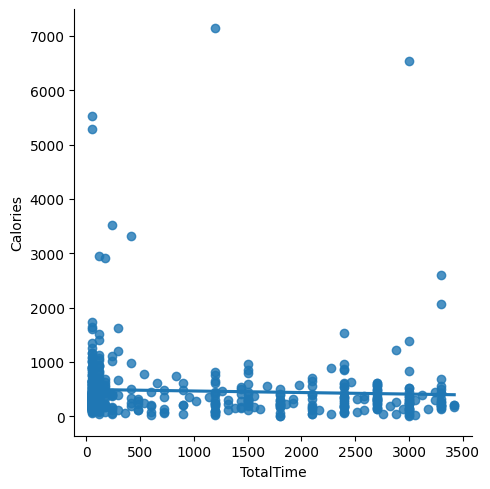

In [10]:
# Exploring how TotalTime relates to Calrories
sns.lmplot(x="TotalTime", y="Calories", data=df, fit_reg=True, ci=None)

/Users/showunmioludotun/PythonProjects/food_rec_system/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


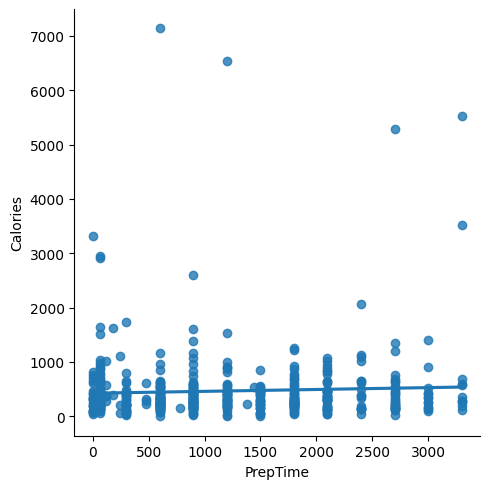

In [11]:
# Exploring how PrepTime relates to Calrories
sns.lmplot(x="PrepTime", y="Calories", data=df, fit_reg=True, ci=None)

/Users/showunmioludotun/PythonProjects/food_rec_system/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


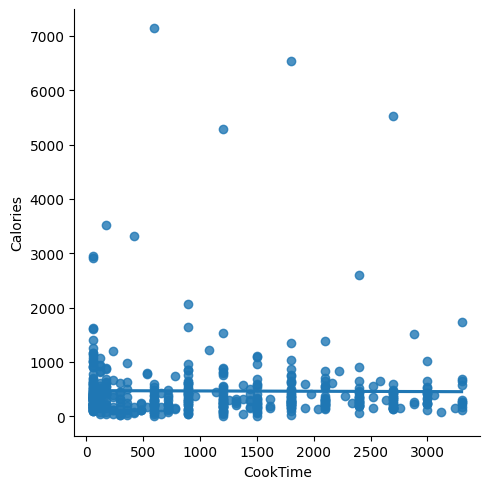

In [12]:
# Exploring how CookTime relates to Calrories
sns.lmplot(x="CookTime", y="Calories", data=df, fit_reg=True, ci=None)

/Users/showunmioludotun/PythonProjects/food_rec_system/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


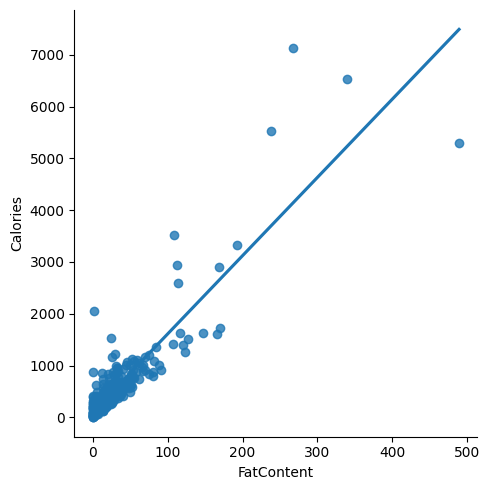

In [13]:
# Exploring how FatContent relates to Calrories
sns.lmplot(x="FatContent", y="Calories", data=df, fit_reg=True, ci=None)

/Users/showunmioludotun/PythonProjects/food_rec_system/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


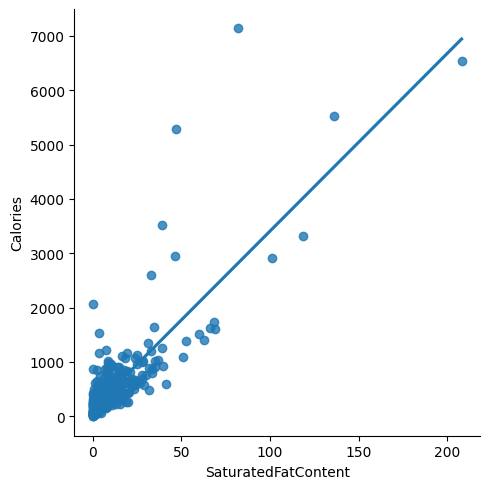

In [14]:
# Exploring how SaturatedFatContent relates to Calrories
sns.lmplot(x="SaturatedFatContent", y="Calories", data=df, fit_reg=True, ci=None)

/Users/showunmioludotun/PythonProjects/food_rec_system/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


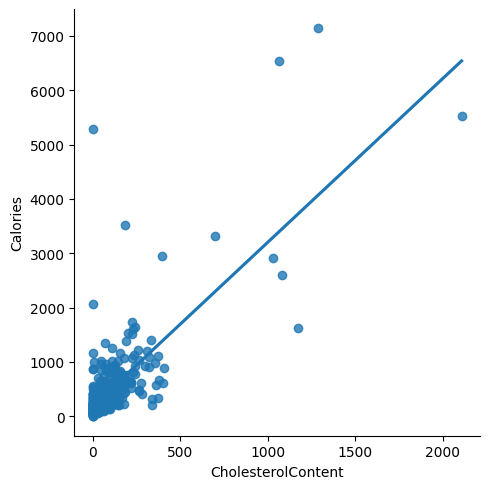

In [15]:
# Exploring how CholesterolContent relates to Calrories
sns.lmplot(x="CholesterolContent", y="Calories", data=df, fit_reg=True, ci=None)

/Users/showunmioludotun/PythonProjects/food_rec_system/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


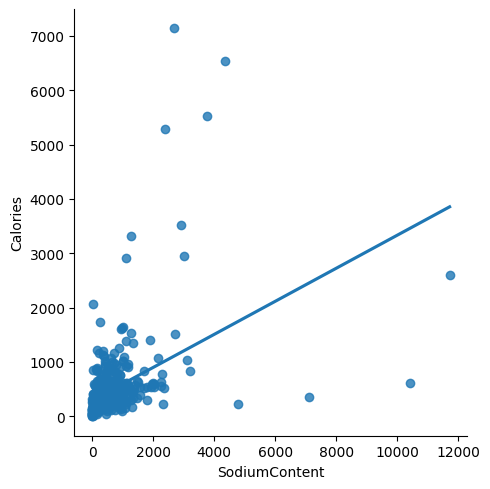

In [16]:
# Exploring how SodiumContent relates to Calrories
sns.lmplot(x="SodiumContent", y="Calories", data=df, fit_reg=True, ci=None)

/Users/showunmioludotun/PythonProjects/food_rec_system/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


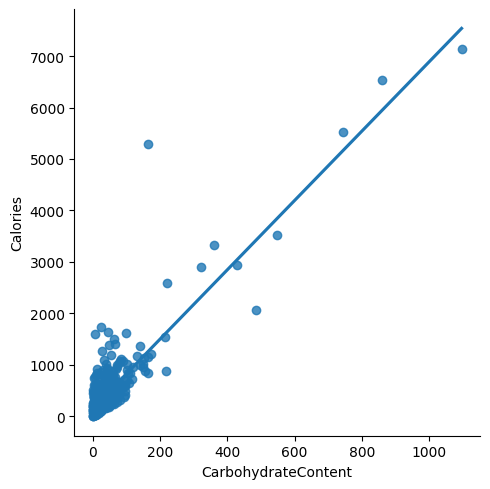

In [17]:
# Exploring how CarbohydrateContent relates to Calrories
sns.lmplot(x="CarbohydrateContent", y="Calories", data=df, fit_reg=True, ci=None)

/Users/showunmioludotun/PythonProjects/food_rec_system/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


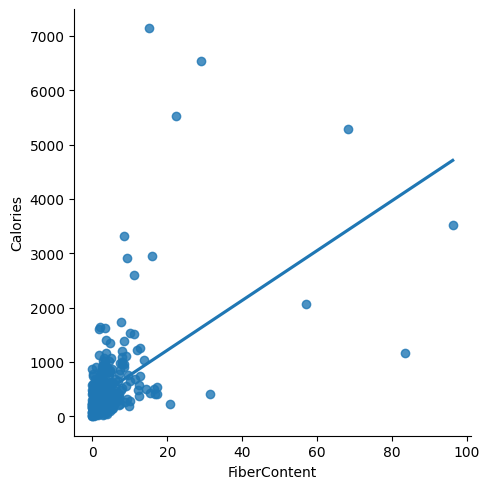

In [18]:
# Exploring how FiberContent relates to Calrories
sns.lmplot(x="FiberContent", y="Calories", data=df, fit_reg=True, ci=None)

/Users/showunmioludotun/PythonProjects/food_rec_system/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


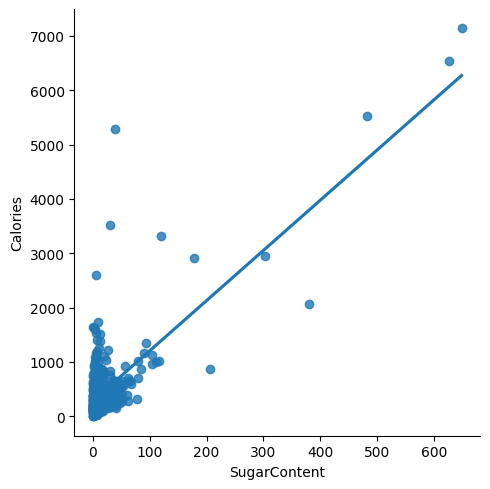

In [19]:
# Exploring how SugarContent relates to Calrories
sns.lmplot(x="SugarContent", y="Calories", data=df, fit_reg=True, ci=None)

/Users/showunmioludotun/PythonProjects/food_rec_system/venv/lib/python3.11/site-packages/seaborn/axisgrid.py:118: UserWarning: The figure layout has changed to tight
  self._figure.tight_layout(*args, **kwargs)


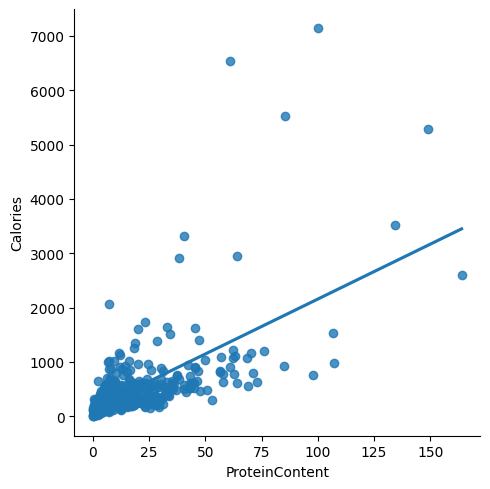

In [20]:
# Exploring how ProteinContent relates to Calrories
sns.lmplot(x="ProteinContent", y="Calories", data=df, fit_reg=True, ci=None)

**Feature Extraction and Transformation:**

Next, we extract the relevant features for the recommendation system. For the Nearest Neighbors algorithm, we use columns related to food contents ('FatContent', 'SaturatedFatContent', 'CholesterolContent', 'SodiumContent', 'CarbohydrateContent', 'FiberContent', 'SugarContent', 'ProteinContent') as features. For Naive Bayes, we consider 'Calories' as the target variable.

In [36]:
calorie_limit = 400
low_calories_data = df[df['Calories'] < calorie_limit]
low_calories_data

,RecipeId,Barcode,Name,CookTime,PrepTime,TotalTime,Calories,FatContent,SaturatedFatContent,CholesterolContent,SodiumContent,CarbohydrateContent,FiberContent,SugarContent,ProteinContent,RecipeServings,DatePublished,RecipeInstructions,Images
0,38.0,38,Low-Fat Berry Blue Frozen Dessert,1440.0,2700.0,1440.0,170.9,2.5,1.3,8.0,29.8,37.1,3.6,30.2,3.2,4.0,1999-08-09 21:46:00+00:00,"c(""Toss 2 cups berries with sugar."", ""Let stan...","c(""https://img.sndimg.com/food/image/upload/w_..."
2,40.0,40,Best Lemonade,300.0,1800.0,2100.0,311.1,0.2,0.0,0.0,1.8,81.5,0.4,77.2,0.3,4.0,1999-09-05 19:52:00+00:00,"c(""Into a 1 quart Jar with tight fitting lid, ...","c(""https://img.sndimg.com/food/image/upload/w_..."
4,42.0,42,Cabbage Soup,1800.0,1200.0,3000.0,103.6,0.4,0.1,0.0,959.3,25.1,4.8,17.7,4.3,4.0,1999-09-19 06:19:00+00:00,"c(""Mix everything together and bring to a boil...","""https://img.sndimg.com/food/image/upload/w_55..."
7,45.0,45,Buttermilk Pie With Gingersnap Crumb Crust,3000.0,1800.0,60.0,228.0,7.1,1.7,24.5,281.8,37.5,0.5,24.7,4.2,8.0,1999-08-06 00:40:00+00:00,"c(""Preheat oven to 350°F."", ""Make pie crust, u...","""https://img.sndimg.com/food/image/upload/w_55..."
13,51.0,51,Chai Tea,1500.0,900.0,2400.0,69.2,3.8,2.1,12.8,53.2,6.0,0.7,0.0,3.5,4.0,1999-08-16 05:10:00+00:00,"c(""Bring water and spices to boil in saucepan....",character(0)
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1194,2631.0,2631,Stephen's Pork Chop Dinner in a Pan,60.0,900.0,60.0,291.3,7.1,2.4,52.5,780.5,36.9,6.8,3.4,20.5,4.0,1999-08-15 07:20:00+00:00,"c(""Peel potatoes and julienne them i.e. cut in...",character(0)
1195,2632.0,2632,Stir-Fry Beef & Spinach with Noodles,1800.0,0.0,1800.0,299.0,4.2,0.6,0.5,599.9,54.4,4.2,8.0,12.8,4.0,1999-08-13 13:50:00+00:00,"c(""Stack beef steaks; cut lengthwise in half a...",character(0)
1196,2633.0,2633,"Beef, Pepper & Mushroom Kabobs",1800.0,0.0,1800.0,208.8,8.3,2.2,68.0,213.9,6.1,1.5,3.9,27.6,4.0,1999-08-11 19:51:00+00:00,"c(""Trim fat from beef steak; cut into 1 1/4-in...","""https://img.sndimg.com/food/image/upload/w_55..."
1202,2639.0,2639,Sweet Chicken Curry,1500.0,600.0,2100.0,114.2,8.1,2.2,35.5,37.2,1.0,0.2,0.3,9.0,48.0,1999-08-13 13:28:00+00:00,"c(""In a pot, brown the meat, onions and garlic...",character(0)


In [38]:
# Encode the target variable using LabelEncoder
label_encoder = LabelEncoder()
calories_encoded = label_encoder.fit_transform(low_calories_data['Calories'])

In [39]:
# Feature extraction
features = low_calories_data[['FatContent', 'SaturatedFatContent', 'CholesterolContent',
                 'SodiumContent', 'CarbohydrateContent', 'FiberContent',
                 'SugarContent', 'ProteinContent']]

# Target variable
target = calories_encoded


**Algorithm Selection and Model Training:**

We will use KNeighborsRegressor from scikit-learn for the Nearest Neighbors algorithm and GaussianNB for Naive Bayes.

In [40]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(features, target, test_size=0.2, random_state=42)

# Nearest Neighbors model
nn_model = KNeighborsRegressor(n_neighbors=5)
nn_model.fit(X_train, y_train)

# Naive Bayes model
nb_model = GaussianNB()
nb_model.fit(features, target)

GaussianNB()

**Food Recommendation:**

Let's define a function that takes a barcode, finds the closest recipe based on food contents using the Nearest Neighbors model, and then suggests a similar food with fewer calories using Naive Bayes.

In [41]:
def food_recommendation(barcode):
    try:
        # Find the nearest neighbors based on food contents
        barcode_data = df[df['Barcode'] == barcode][['FatContent', 'SaturatedFatContent',
                                                        'CholesterolContent', 'SodiumContent',
                                                        'CarbohydrateContent', 'FiberContent',
                                                        'SugarContent', 'ProteinContent']]
        
        
        k = 1
        nn_recipe_idxs = nn_model.kneighbors(barcode_data, n_neighbors=k, return_distance=False)[0]
        
        # Get the recommended recipe based on Nearest Neighbors
        nn_recipes = [df.iloc[nn_recipe_idx]['Name'] for nn_recipe_idx in nn_recipe_idxs]

        # Use Naive Bayes to find a similar recipe with fewer calories
        # calorie_limit = 400
        similar_food_idx = nb_model.predict(barcode_data)[0]
        print(similar_food_idx)
        similar_food = df[df['Calories'] < calorie_limit].iloc[similar_food_idx]['Name']
    except:
        nn_recipes = 'Food Data Not Found'
        similar_food = 'Food Data Not Found'

    return nn_recipes , similar_food


**Testing:**

We then test out the recommendation system

In [43]:
# Test
# Example of food recommendation using barcode '38'
nn_recipes, similar_food = food_recommendation(41)
print(f"Nearest Neighbors Recommended Recipes: {nn_recipes}")
print(f"Naive Bayes Recommended Recipe (with fewer calories): {similar_food}")

228
Nearest Neighbors Recommended Recipes: ['Chicken Roll-Ups']
Naive Bayes Recommended Recipe (with fewer calories): Walter Mcilhenney's Chili Con Carne


**Performance Evaluation:**

To evaluate the models' performance, we'll calculate the R-squared score for the Nearest Neighbors algorithm and use accuracy, precision, recall, and F1-score for the Naive Bayes algorithm.

In [46]:
# Evaluation
# Nearest Neighbors evaluation
nn_r2_score = r2_score(y_test, nn_model.predict(X_test))

# Naive Bayes evaluation
nb_pred = nb_model.predict(X_test)
nb_accuracy = accuracy_score(y_test, nb_pred)
nb_precision = precision_score(y_test, nb_pred, average='weighted')
nb_recall = recall_score(y_test, nb_pred, average='weighted')
nb_f1_score = f1_score(y_test, nb_pred, average='weighted')

print(f"Nearest Neighbors R-squared Score: {nn_r2_score:.2f}")
print(f"Naive Bayes Accuracy: {nb_accuracy:.2f}")
print(f"Naive Bayes Precision: {nb_precision:.2f}")
print(f"Naive Bayes Recall: {nb_recall:.2f}")
print(f"Naive Bayes F1 Score: {nb_f1_score:.2f}")

Nearest Neighbors R-squared Score: 0.58
Naive Bayes Accuracy: 1.00
Naive Bayes Precision: 1.00
Naive Bayes Recall: 1.00
Naive Bayes F1 Score: 1.00


**Visualization:**

To add some visualizations, we create a correlation matrix and a history plot.

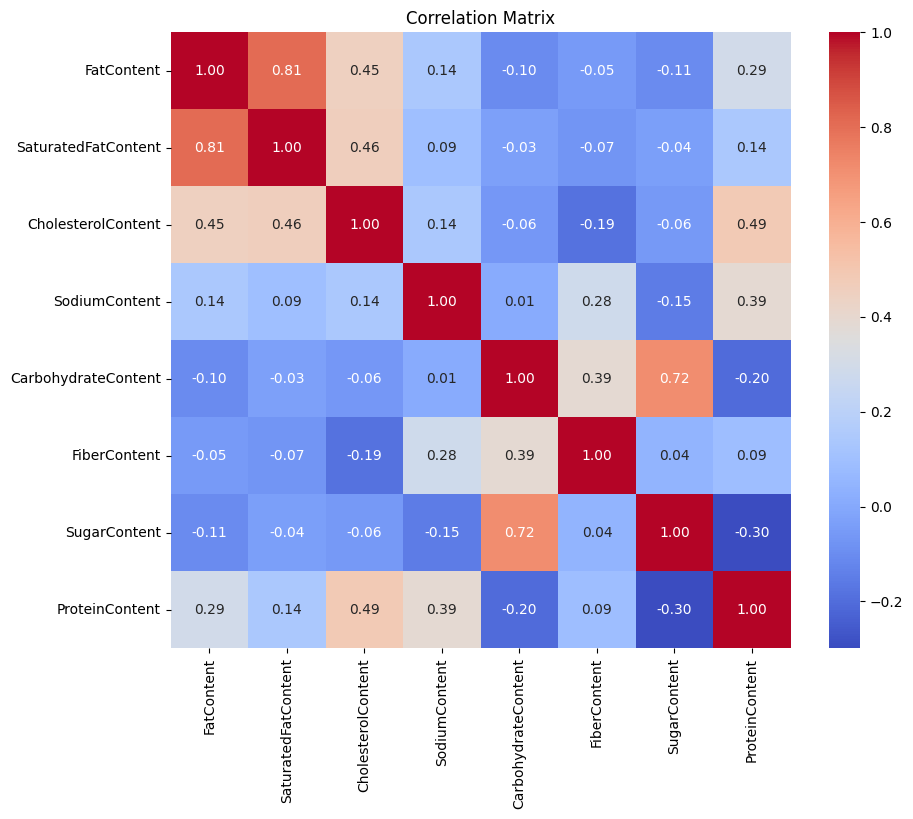

In [47]:
# Visualization
import seaborn as sns
# Correlation matrix
correlation_matrix = features.corr()
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix')
plt.show()

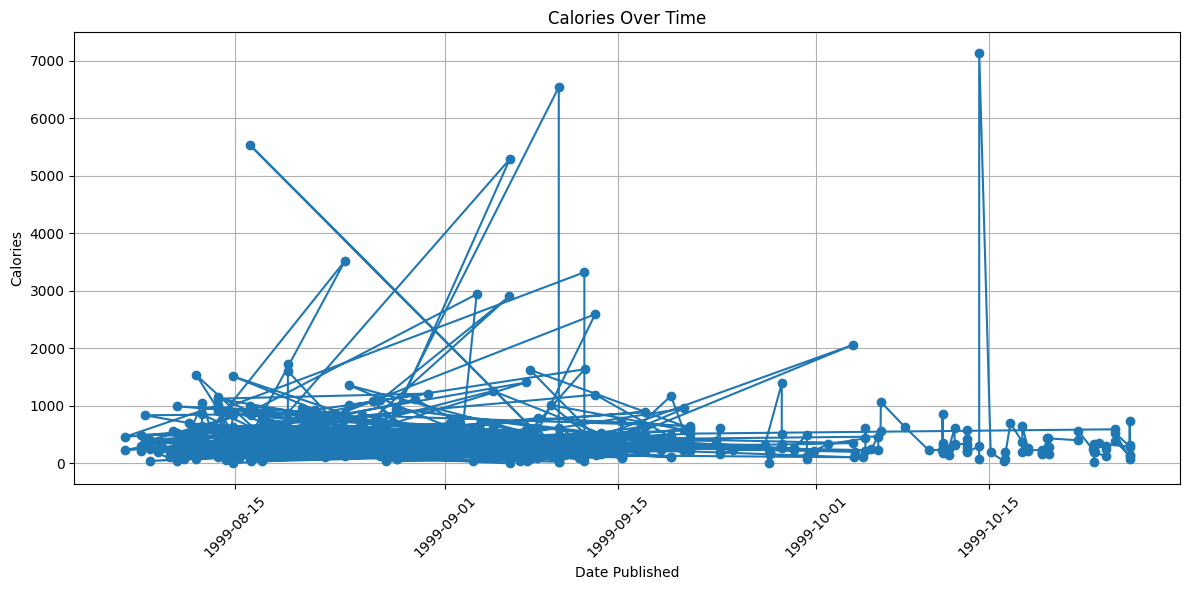

In [48]:
# History plot
plt.figure(figsize=(12, 6))
plt.plot(df['DatePublished'], df['Calories'], marker='o')
plt.xlabel('Date Published')
plt.ylabel('Calories')
plt.title('Calories Over Time')
plt.xticks(rotation=45)
plt.grid(True)
plt.tight_layout()
plt.show()